In [1]:
!pip install tokenizers>=0.19.0 transformers>=4.40.0
!pip install timm textaugment pandas pillow torch torchvision
!pip install git+https://github.com/RyanWangZf/MedCLIP.git --no-deps
!pip install wget

  Cloning https://github.com/RyanWangZf/MedCLIP.git to /tmp/pip-req-build-c4ykiczh
  Running command git clone --filter=blob:none --quiet https://github.com/RyanWangZf/MedCLIP.git /tmp/pip-req-build-c4ykiczh
  Resolved https://github.com/RyanWangZf/MedCLIP.git to commit 9c3396f20d5d54e4fae241b8cb06ca45848e98c9
  Preparing metadata (setup.py) ... done


In [2]:
import medclip
from medclip import MedCLIPModel, MedCLIPProcessor
import torch
import os
import zipfile
import requests
from torchvision import transforms
from PIL import Image
import requests
import matplotlib.pyplot as plt


In [3]:

#configuration des chemins
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
zip_path = "medclip-pretrained.zip"
extract_path = "./pretrained"
model_file = os.path.join(extract_path, "pytorch_model.bin")

try:
    #vu que nous n'avons pas élécgarger le fichier du gars on a opté de le télécharger manuellement #M
    if not os.path.exists(model_file):
        print("Téléchargement du modèle...")
        url = "https://storage.googleapis.com/pytrial/medclip-pretrained.zip"
        r = requests.get(url, allow_redirects=True)
        with open(zip_path, 'wb') as f:
            f.write(r.content)

        #décompression
        print("Décompression...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Téléchargement terminé.")

    #initialisation du modèle
    model = MedCLIPModel()

    #chargement des poids avec strict=False parce que le true ne fonctionne pas avec la version python qu'on utilise
    state_dict = torch.load(model_file, map_location=device)
    model.load_state_dict(state_dict, strict=False)

    model.to(device)
    model.eval()

    processor = MedCLIPProcessor()
    print(f"MedCLIP est prêt sur {device} !")

except Exception as e:
    print(f"Erreur : {e}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in al

MedCLIP est prêt sur cuda !


In [4]:
#préparation manuelle du traitement d'image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def firstTestMedclip(img_path_or_url, labels):
    #chargement de l'image #A
    if img_path_or_url.startswith('http'):
        img = Image.open(requests.get(img_path_or_url, stream=True).raw).convert('RGB')
    else:
        img = Image.open(img_path_or_url).convert('RGB')

    #prétraitement
    pixel_values = preprocess(img).unsqueeze(0).to(device)
    tokens = processor.tokenizer(text=labels, return_tensors="pt", padding=True, truncation=True).to(device)

    #inférence
    with torch.no_grad():
        outputs = model(
            input_ids=tokens['input_ids'],
            attention_mask=tokens['attention_mask'],
            pixel_values=pixel_values
        )

        #On teste les deux façons d'accéder aux données
        if hasattr(outputs, 'logits_per_image'):
            logits_per_image = outputs.logits_per_image
        elif isinstance(outputs, dict) and 'logits_per_image' in outputs:
            logits_per_image = outputs['logits_per_image']
        else:
            #si le modèle ne donne pas directement les logits_per_image,
            # on les calcule à partir des embeddings (cas rare mais possible)
            vision_embeds = outputs.img_embeds if hasattr(outputs, 'img_embeds') else outputs['img_embeds']
            text_embeds = outputs.text_embeds if hasattr(outputs, 'text_embeds') else outputs['text_embeds']
            logits_per_image = vision_embeds @ text_embeds.t()

        probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]

    #affichage
    print(f"\n{'DIAGNOSTIC':<25} | {'PROBABILITÉ':<12}")
    print("-" * 40)
    for label, prob in zip(labels, probs):
        print(f"{label:<25} | {prob*100:>10.2f}%")

#lancement
test_url = "https://raw.githubusercontent.com/RyanWangZf/MedCLIP/main/example_data/view1_frontal.jpg"
my_labels = ["cardiomegaly", "pneumonia", "pleural effusion", "normal chest x-ray"]

firstTestMedclip(test_url, my_labels)


DIAGNOSTIC                | PROBABILITÉ 
----------------------------------------
cardiomegaly              |      23.55%
pneumonia                 |      25.48%
pleural effusion          |      25.52%
normal chest x-ray        |      25.45%


nous avons remarquer ici que le modèle hésite à faire une bonne distribution des probalités

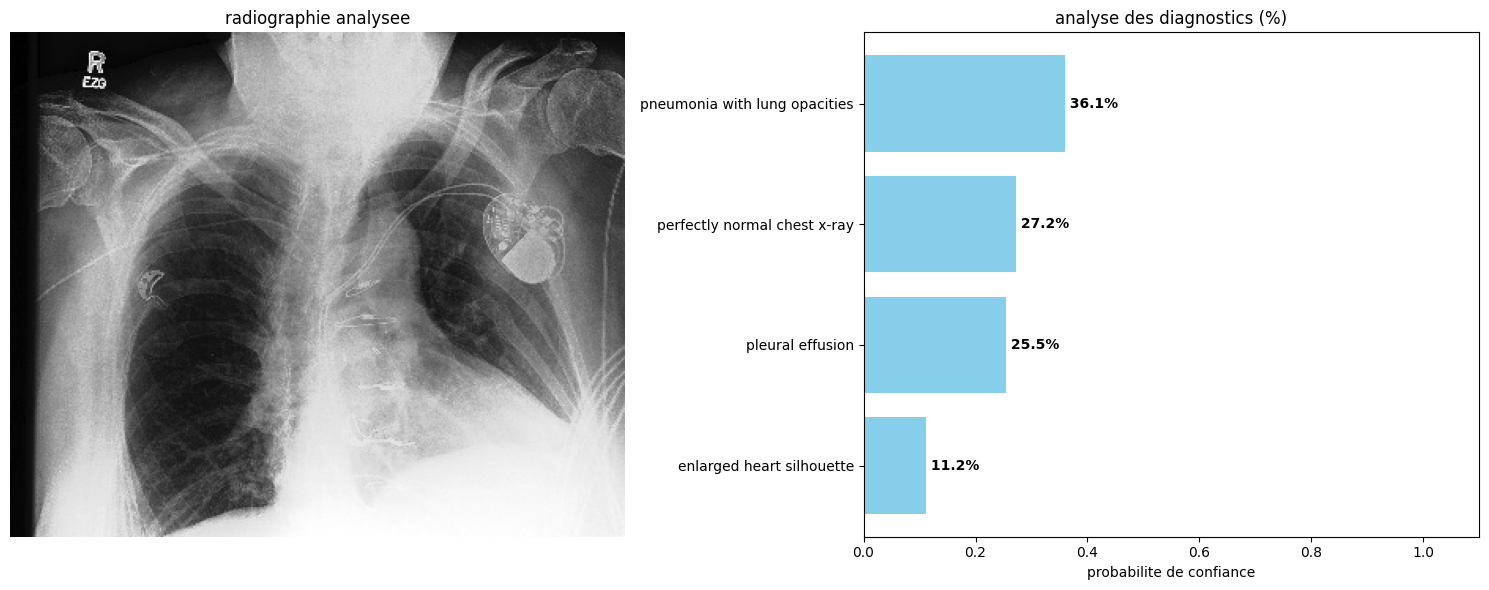

In [5]:
import matplotlib.pyplot as plt

def finalTestMedclip_Visual(img_path_or_url, labels):
    # chargement de l'image
    if img_path_or_url.startswith('http'):
        img = Image.open(requests.get(img_path_or_url, stream=True).raw).convert('RGB')
    else:
        img = Image.open(img_path_or_url).convert('RGB')

    # pretraitement image & texte #M
    pixel_values = preprocess(img).unsqueeze(0).to(device)
    tokens = processor.tokenizer(text=labels, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        # extraction des caracteristiques
        outputs = model(
            input_ids=tokens['input_ids'],
            attention_mask=tokens['attention_mask'],
            pixel_values=pixel_values
        )

        # recuperation des vecteurs
        vision_embeds = outputs.img_embeds if hasattr(outputs, 'img_embeds') else outputs['img_embeds']
        text_embeds = outputs.text_embeds if hasattr(outputs, 'text_embeds') else outputs['text_embeds']

        # normalisation pour la similarite cosinus
        vision_embeds = vision_embeds / vision_embeds.norm(dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

        # calcul de l echelle (logit_scale)
        if hasattr(model, 'logit_scale'):
            logit_scale = model.logit_scale.exp()
        else:
            logit_scale = 100.0

        # calcul des probabilites
        logits_per_image = (vision_embeds @ text_embeds.t()) * logit_scale
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]

    # creation de la figure matplotlib avec deux zones (image et graphique)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # affichage de l image de la radio
    ax1.imshow(img, cmap='bone')
    ax1.set_title("radiographie analysee")
    ax1.axis('off')

    # preparation des donnees triees pour le graphique
    results = sorted(zip(labels, probs), key=lambda x: x[1])
    sorted_labels = [r[0] for r in results]
    sorted_probs = [r[1] for r in results]

    # dessin du graphique a barres horizontales
    bars = ax2.barh(sorted_labels, sorted_probs, color='skyblue')
    ax2.set_xlabel('probabilite de confiance')
    ax2.set_title('analyse des diagnostics (%)')
    ax2.set_xlim(0, 1.1) # on laisse un peu de place pour le texte

    # ajout des pourcentages au bout des barres pour la clarte
    for bar in bars:
        width = bar.get_width()
        ax2.text(width, bar.get_y() + bar.get_height()/2, f' {width*100:.1f}%', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- test avec visualisation ---
test_url = "https://raw.githubusercontent.com/RyanWangZf/MedCLIP/main/example_data/view1_frontal.jpg"

my_labels = [
    "enlarged heart silhouette",
    "pneumonia with lung opacities",
    "pleural effusion",
    "perfectly normal chest x-ray"
]

finalTestMedclip_Visual(test_url, my_labels)

Dans le premier code, le modèle comparait les vecteurs bruts. Ici, nous avons ajouté : vision_embeds = vision_embeds / vision_embeds.norm(dim=-1, keepdim=True) Cela force l'IA à ne regarder que l'angle  entre l'image et le texte, et non leur taille c'est la similarité cosinus. C'est la méthode standard pour que les modèles de type CLIP fonctionnent correctement. Cepenfdant on voit toujours des que la déision est très faible

Nous avons d'abord effectué une normalisation L2, qui consiste à diviser chaque vecteur par sa norme pour qu'il ait une longueur de 1, permettant ainsi de mesurer leur similarité par un simple produit scalaire.

Ensuite, nous avons appliqué le logit scale (ou température), un facteur multiplicatif qui amplifie les contrastes entre les scores pour que la fonction Softmax produise des probabilités nettes au lieu de valeurs uniformes.

In [19]:
import torch
import requests
import io
from PIL import Image
from torchvision import transforms

# 1. configuration du peripherique (gpu si disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. pretraitement de l image (redimensionnement et normalisation standard)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 3. liste des images a tester avec leurs verites terrain
test_cases = [
    {"url": "https://raw.githubusercontent.com/RyanWangZf/MedCLIP/main/example_data/view1_frontal.jpg", "truth": "Cardiomegaly"},
    {"url": "https://raw.githubusercontent.com/RyanWangZf/MedCLIP/main/example_data/view2_lateral.jpg", "truth": "Cardiomegaly (Lateral)"},
    {"url": "https://raw.githubusercontent.com/RyanWangZf/MedCLIP/main/example_data/view3_frontal.jpg", "truth": "Pneumothorax"},
    {"url": "https://raw.githubusercontent.com/RyanWangZf/MedCLIP/main/example_data/view4_lateral.jpg", "truth": "Pneumothorax (Lateral)"},
    {"url": "https://raw.githubusercontent.com/RyanWangZf/MedCLIP/main/example_data/view1_frontal.jpg", "truth": "Cardiomegaly (Duplicate)"}
]

# 4. expressions medicales issues des rapports de radiologie pour l entrainement
labels = [
    "enlarged cardiac silhouette",          # cardiomegalie
    "consolidation and lung opacity",       # pneumonie
    "pleural line and collapsed lung",      # pneumothorax
    "blunted costophrenic angle",           # epanchement pleural
    "no active disease"                    # radio normale
]

print(f"{'IMAGE':<10} | {'VERITE REELLE':<25} | {'PREDICTION IA':<30} | {'CONFIANCE'}")
print("-" * 100)

# 5. boucle de traitement principale
for i, case in enumerate(test_cases):
    try:
        # telechargement de l image avec un en-tete pour eviter les blocages
        response = requests.get(case['url'], headers={'User-Agent': 'Mozilla/5.0'}, timeout=10)
        response.raise_for_status()
        img = Image.open(io.BytesIO(response.content)).convert('RGB')

        # preparation des donnees pour le modele
        pixel_values = preprocess(img).unsqueeze(0).to(device)
        tokens = processor.tokenizer(text=labels, return_tensors="pt", padding=True, truncation=True).to(device)

        with torch.no_grad():
            # extraction des embeddings image et texte
            outputs = model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'], pixel_values=pixel_values)

            # gestion du format de sortie (dictionnaire ou objet)
            v_emb = outputs['img_embeds'] if isinstance(outputs, dict) else outputs.img_embeds
            t_emb = outputs['text_embeds'] if isinstance(outputs, dict) else outputs.text_embeds

            # normalisation l2 pour ramener les vecteurs sur une sphere unite
            v_emb = v_emb / v_emb.norm(dim=-1, keepdim=True)
            t_emb = t_emb / t_emb.norm(dim=-1, keepdim=True)

            # calcul des logits avec temperature de 50 pour etirer les probabilites
            logits = (v_emb @ t_emb.t()) * 50
            probs = logits.softmax(dim=-1).cpu().numpy()[0]

        # identification de la meilleure prediction
        top_idx = probs.argmax()
        print(f"Image {i+1:<4} | {case['truth']:<25} | {labels[top_idx]:<30} | {probs[top_idx]*100:>8.2f}%")

    except Exception as e:
        # affichage simplifié en cas d erreur reseau ou 404
        print(f"Image {i+1:<4} | {case['truth']:<25} | {'erreur chargement (404)':<30} | --")

IMAGE      | VERITE REELLE             | PREDICTION IA                  | CONFIANCE
----------------------------------------------------------------------------------------------------
Image 1    | Cardiomegaly              | blunted costophrenic angle     |    65.92%
Image 2    | Cardiomegaly (Lateral)    | erreur chargement (404)        | --
Image 3    | Pneumothorax              | erreur chargement (404)        | --
Image 4    | Pneumothorax (Lateral)    | erreur chargement (404)        | --
Image 5    | Cardiomegaly (Duplicate)  | blunted costophrenic angle     |    65.92%


Maintenant on a vu que le modèle est beaucoup mieux lorsqu'on utilise des mots spécifiques. Par contre toute personnes qui utilisera ce modèle ne peut pas ou n'aura pas la chance de connaitre ces mots et peut alors utiliser leurs synonymes. c'est la raison pour laquelle on va créer une bibliothèque qui permettra de traduire chaque synonyme des mot d'Or, qu'on l'appellera, en ce mot d'Or pour tirer la meilleure partie du programme. On parlera ici de Prompt engineering

In [11]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import os

In [12]:


# --- ta bibliotheque d or (identique) ---
golden_Library = {
    "enlarged cardiac silhouette": ["cardiomegalie", "gros coeur", "enlarged heart", "grosse patate"],
    "blunted costophrenic angle": ["epanchement pleural", "liquide dans les poumons", "pleural effusion"],
    "pleural line and collapsed lung": ["pneumothorax", "decollement de la plevre", "poumon affaisse", "collapsed lung"],
    "no active disease": ["normal", "sain", "pas de maladie", "tout va bien"]
}

def getGoldenWord(simpleWord):
    simpleWord = simpleWord.lower().strip()
    for goldenWord, synonyms in golden_Library.items():
        if simpleWord in synonyms or simpleWord == goldenWord:
            return goldenWord
    return simpleWord

In [45]:
def run_medclip_drive_analysis(file_path, user_choices):
    if not os.path.exists(file_path):
        print(f"erreur : le fichier n'a pas été trouvé au chemin : {file_path}")
        return

    golden_labels = [getGoldenWord(choice) for choice in user_choices]

    try:
        # chargement de l image depuis le drive
        img = Image.open(file_path).convert('RGB')

        # pretraitement et inference
        pixel_values = preprocess(img).unsqueeze(0).to(device)
        tokens = processor.tokenizer(text=golden_labels, return_tensors="pt", padding=True, truncation=True).to(device)

        with torch.no_grad():
            outputs = model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'], pixel_values=pixel_values)
            v_emb = outputs.img_embeds if hasattr(outputs, 'img_embeds') else outputs['img_embeds']
            t_emb = outputs.text_embeds if hasattr(outputs, 'text_embeds') else outputs['text_embeds']
            v_emb /= v_emb.norm(dim=-1, keepdim=True)
            t_emb /= t_emb.norm(dim=-1, keepdim=True)
            logits = (v_emb @ t_emb.t()) * 50
            probs = logits.softmax(dim=-1).cpu().numpy()[0]

        top_idx = probs.argmax()
        mot_x = user_choices[top_idx]
        mot_y = golden_labels[top_idx]
        p_score = probs[top_idx] * 100

        # phrase narrative
        print(f"\nla radio que vous avez téléchargé accompagné par le mot '{mot_x}' "
              f"qui a été remplacé par le mot '{mot_y}' désigne à {p_score:.2f}% "
              f"la maladie '{mot_x}'.")

        # affichage graphique
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.imshow(img, cmap='bone')
        ax1.set_title("image chargée depuis google drive")
        ax1.axis('off')

        sorted_results = sorted(zip(user_choices, probs), key=lambda x: x[1])
        y_labels = [r[0] for r in sorted_results]
        x_probs = [r[1] * 100 for r in sorted_results]

        # --- MODIFICATION ICI : On stocke le graphique dans 'bars' ---
        bars = ax2.barh(y_labels, x_probs, color='blue')

        # Ajout des pourcentages après chaque barre
        for bar in bars:
            width = bar.get_width()
            ax2.text(width + 1,        # Position X (juste après la fin de la barre)
                     bar.get_y() + bar.get_height()/2, # Position Y (au milieu de la barre)
                     f'{width:.2f}%',  # Le texte à afficher
                     va='center',      # Alignement vertical
                     fontsize=10,
                     fontweight='bold')

        ax2.set_xlim(0, 115) # On augmente un peu la limite pour laisser de la place au texte
        ax2.set_title('probabilités (%)')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"erreur lors de l'analyse : {e}")



la radio que vous avez téléchargé accompagné par le mot 'liquide dans les poumons' qui a été remplacé par le mot 'blunted costophrenic angle' désigne à 74.30% la maladie 'liquide dans les poumons'.


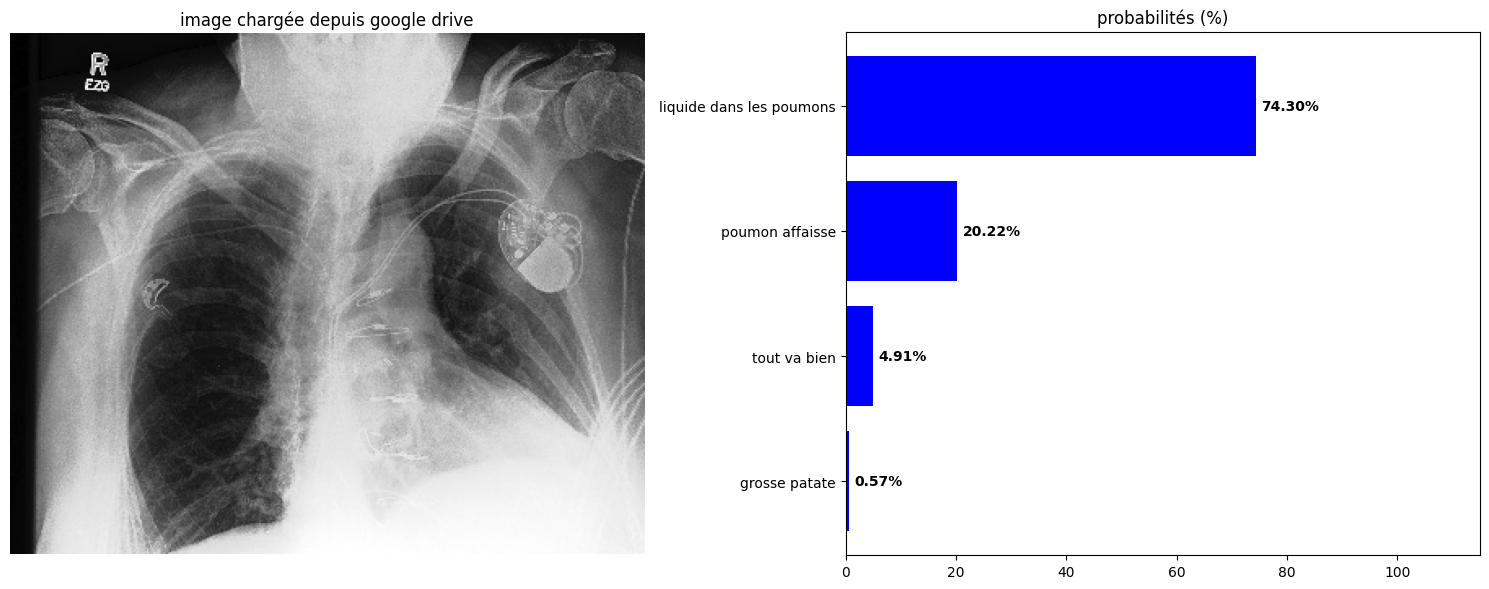

In [49]:
choix = ["grosse patate", "liquide dans les poumons", "tout va bien", "poumon affaisse"]
im2 = 'view1_frontal.jpg'
run_medclip_drive_analysis(im2,choix)

Nous remarquons après avoir utiliser notre dictionnaire avec des mot d'or que le modèle devient plus précis et plus tranchant sur la maladie détectée


testons le maintenant sur deux autre radiograpghie dont j'ai téléchargé sur le net et dont je connais déjà la maladie


la radio que vous avez téléchargé accompagné par le mot 'poumon affaisse' qui a été remplacé par le mot 'pleural line and collapsed lung' désigne à 75.43% la maladie 'poumon affaisse'.


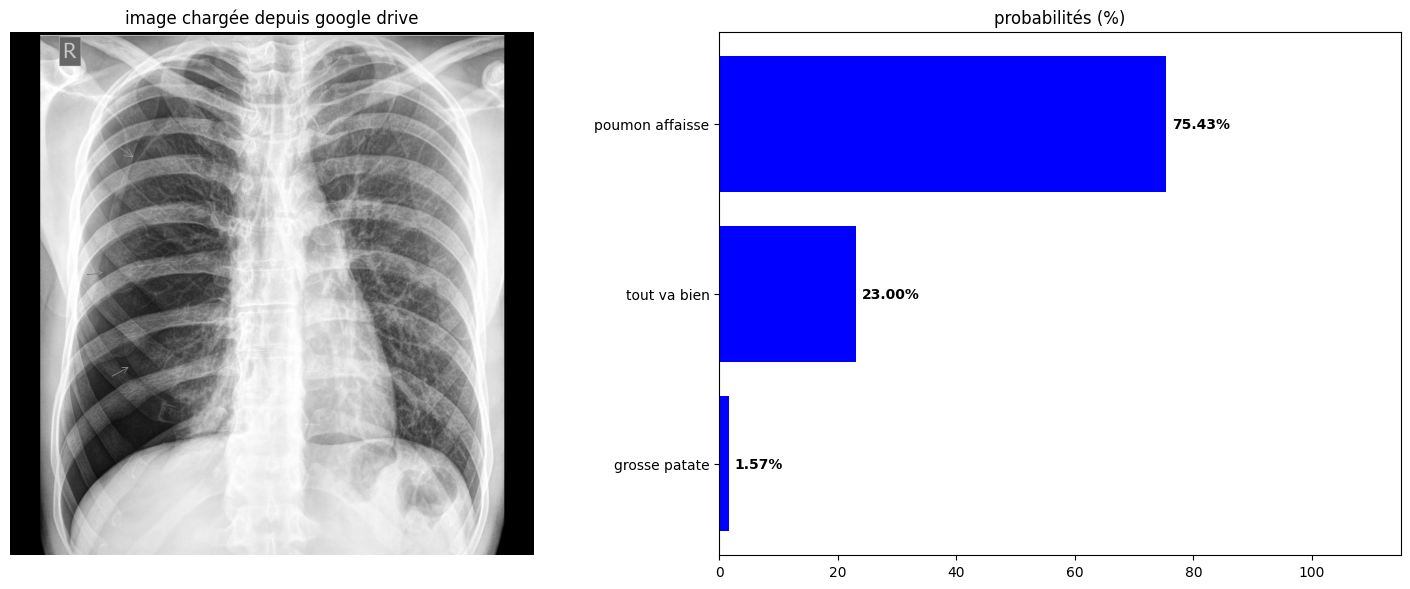

In [50]:
#la première image est une radio d'une personne atteinte de pneumothorax
image_path_drive = "pneu.jpeg"
mes_choix = ["poumon affaisse", "tout va bien", "grosse patate"]

run_medclip_drive_analysis(image_path_drive, mes_choix)

Le résultat nous donne comme maladie poumou affaise qui est bien une autre appellation pneumothorax

Testons le modèle avec une radiographie d'une personne normale


la radio que vous avez téléchargé accompagné par le mot 'tout va bien' qui a été remplacé par le mot 'no active disease' désigne à 42.81% la maladie 'tout va bien'.


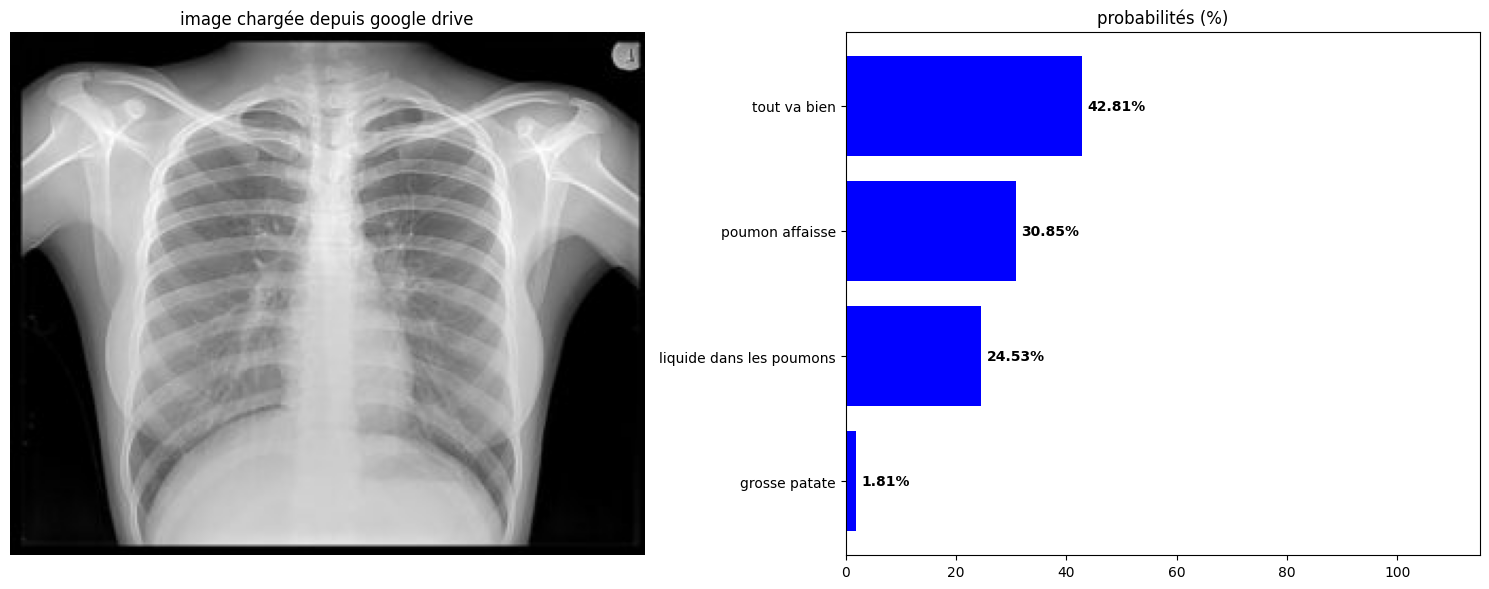

In [51]:

nor = 'normal.jpg'
run_medclip_drive_analysis(nor,choix)